# Data pre-processing and clenup 
We will be using the spacy library.   
https://allenai.github.io/scispacy/

In [78]:
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_sm
import en_core_sci_md
import pandas as pd
pd.options.mode.chained_assignment = None 
from tqdm import tqdm
import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

### Importing Spacy language models

In [ ]:
!python3 -m pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz   
!python3 -m pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_sm-0.4.0.tar.gz
!python3 -m pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_md-0.4.0.tar.gz
import en_core_sci_lg
import en_core_sci_sm
import en_core_sci_md    

#### Validate Spacy data models

In [79]:
!python3 -m spacy validate

✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.0.7) =================
ℹ spaCy installation:
/Users/dantohe/Library/Python/3.8/lib/python/site-packages/spacy

NAME             SPACY            VERSION                            
en_core_sci_md   >=3.0.1,<3.1.0   0.4.0   ✔
en_core_sci_sm   >=3.0.1,<3.1.0   0.4.0   ✔
en_core_web_sm   >=3.0.0,<3.1.0   3.0.0   ✔



### Punctuation and stop words

In [80]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:5]

['through', 'one', 'indeed', 'least', 'every']

#### Augmenting the list of stop words
Credits: https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles#Latend-Dirichlet-Allocation   

In [81]:
additional_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'p', '2', '1', '3', 'l'
]

for w in additional_stop_words:
    if w not in stopwords:
        stopwords.append(w)

### Processing titles and abstracts
Prepare the spacy processor.

In [82]:
processor = en_core_sci_md.load(disable=["tagger", "ner"])
processor.max_length = 7000000

def spacy_processor(sentence):
    my_string = processor(sentence)
    my_string = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in my_string ]
    my_string = [ word for word in my_string if word not in stopwords and word not in punctuations ]
    my_string = " ".join([i for i in my_string])
    return my_string

### Load the dataframe from the previous processing

In [83]:
cord_metadata_processed = pd.read_csv('temp/metadata_2_language_en.zip')
metadata = cord_metadata_processed.copy(deep=True)
print(metadata.columns)
print(f'Frame dimentions {metadata.shape}')

Index(['Unnamed: 0', 'Unnamed: 0.1', 'cord_uid', 'sha', 'source_x', 'title',
       'doi', 'pmcid', 'pubmed_id', 'license', 'abstract', 'publish_time',
       'authors', 'journal', 'url', 'selection', 'language'],
      dtype='object')
Frame dimentions (117578, 17)


### Assesing Spacy speed on a data subset
Picking 100 rows.

In [84]:
metadata_subset = metadata[0:100]
print(f'Frame dimentions {metadata_subset.shape}')

Frame dimentions (100, 17)


#### Processing a subset of titles

In [85]:
tqdm.pandas()
metadata_subset["processed_title"] = metadata_subset["title"].progress_apply(spacy_processor)


100%|██████████| 100/100 [00:00<00:00, 154.00it/s]


In [91]:
print(metadata_subset.shape)
print(metadata_subset[["title","processed_title"]])

(100, 18)
                                                title  \
0   Nitric oxide: a pro-inflammatory mediator in l...   
1                Role of endothelin-1 in lung disease   
2   Sequence requirements for RNA strand transfer ...   
3   The 21st International Symposium on Intensive ...   
4   Technical Description of RODS: A Real-time Pub...   
..                                                ...   
95  Endothelial Cells Support Persistent Gammaherp...   
96                 Animal models of acute lung injury   
97  Activation of the Unfolded Protein Response Is...   
98  Prevention of Cytotoxic T Cell Escape Using a ...   
99  Multiorgan failure due to hemophagocytic syndr...   

                                      processed_title  
0   nitric oxide pro-inflammatory mediator lung di...  
1                      role endothelin-1 lung disease  
2   sequence requirements rna strand transfer nido...  
3   21st international symposium intensive care em...  
4   technical description

#### Processing a subset of abstracts

In [92]:
metadata_subset["processed_abstract"] = metadata_subset["abstract"].progress_apply(spacy_processor)


100%|██████████| 100/100 [00:03<00:00, 25.99it/s]


In [94]:
print(metadata_subset.shape)
print(metadata_subset[["abstract","processed_abstract"]])

(100, 19)
                                             abstract  \
0   Inflammatory diseases of the respiratory tract...   
1   Endothelin-1 (ET-1) is a 21 amino acid peptide...   
2   Nidovirus subgenomic mRNAs contain a leader se...   
3   The 21st International Symposium on Intensive ...   
4   This report describes the design and implement...   
..                                                ...   
95  A variety of human diseases are associated wit...   
96  Acute lung injury in humans is characterized h...   
97  Pore-forming toxins (PFTs) constitute the sing...   
98  High affinity antigen-specific T cells play a ...   
99  INTRODUCTION: Hemophagocytic syndrome (HFS) is...   

                                   processed_abstract  
0   inflammatory diseases respiratory tract common...  
1   endothelin-1 et-1 21 amino acid peptide divers...  
2   nidovirus subgenomic mrnas contain leader sequ...  
3   21st international symposium intensive care em...  
4   report describes desi

### Performing the text processing on the whole dataframe
#### Title processing

In [95]:
metadata["title_processed"] = metadata["title"].progress_apply(spacy_processor)

100%|██████████| 117578/117578 [10:13<00:00, 191.78it/s]


In [96]:
metadata["title_processed"]

0         nitric oxide pro-inflammatory mediator lung di...
1                            role endothelin-1 lung disease
2         sequence requirements rna strand transfer nido...
3         21st international symposium intensive care em...
4         technical description rods real-time public he...
                                ...                        
117573    brainstem encephalitis associated chandipura a...
117574    optimal control theory approach non-pharmaceut...
117575    endophytes treasure house bioactive compounds ...
117576    proteomic strategies discovery novel diagnosti...
117577    impact middle east respiratory syndrome corona...
Name: title_processed, Length: 117578, dtype: object

#### Abstract processing

In [97]:
metadata["abstract_processed"] = metadata["abstract"].progress_apply(spacy_processor)

100%|██████████| 117578/117578 [1:03:36<00:00, 30.81it/s]


In [98]:
compression_opts = dict(method='zip',
                        archive_name='out.csv')  
metadata.to_csv('temp/metadata_spacy_processed.zip', index=True,
          compression=compression_opts)  

In [99]:
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords

def word_bar_graph_function(dataframe,column,title):
    # adapted from https://www.kaggle.com/benhamner/most-common-forum-topic-words
    topic_words = [ z.lower() for y in
                       [ x.split() for x in dataframe[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    plt.title(title)
    plt.show()

### Performing a fast assesment of the results
#### Title results

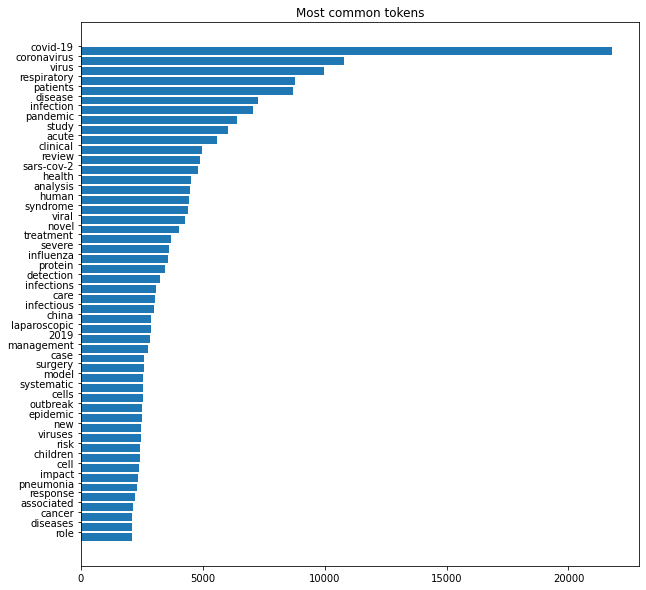

In [100]:
plt.figure(figsize=(10,10))
word_bar_graph_function(metadata,column='title_processed', title='Most common tokens')

### Abstract results

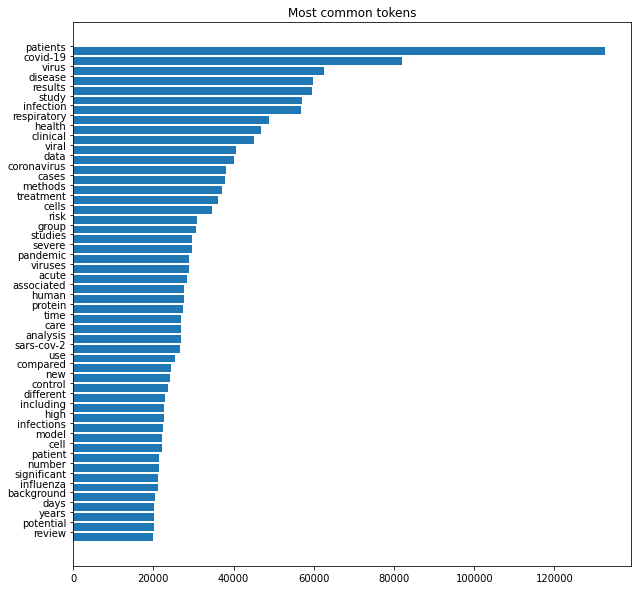

In [101]:
plt.figure(figsize=(10,10))
word_bar_graph_function(metadata,column='abstract_processed', title='Most common tokens')